<a href="https://colab.research.google.com/github/Miklneuro/Chemikal_kursovaya_work/blob/main/%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_IC50%3E_%D0%BC%D0%B5%D0%B4%D0%B8%D0%B0%D0%BD%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip  install catboost optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 7.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)


import optuna
from optuna.samplers import TPESampler

# Вспомогательные
from sklearn.base import clone
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.metrics import roc_curve, auc

/usr/local/lib/python3.11/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [3]:
data = pd.read_csv('/content/drive/MyDrive/MIFI_kurs_chemickal_data/processed_data.csv')

In [4]:
X = data.drop(columns=['IC50, mM', 'CC50, mM', 'SI'])
y = data['IC50, mM']  # Целевая переменная (1D массив)

In [5]:
# Разделение на train и test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=pd.qcut(y, q=10),  # сохраняем распределение для корректной стратификации
    random_state=42
)

In [6]:
# Вычисление медианы ТОЛЬКО по трейну
median_ic50 = y_train.median()

In [11]:
# Преобразование в задачу классификации: IC50 > медиана трейна?
y_class = (y > median_ic50).astype(int)

| Метрика | Описание | Зачем нужна |
|--------|----------|-------------|
| **Accuracy** | Доля правильных предсказаний среди общего числа | Общая мера эффективности модели; удобна при сбалансированных классах |
| **Precision (Точность)** | Доля верно предсказанных положительных объектов среди всех предсказанных положительных | Важна, когда ложные срабатывания критичны (например, дорого проверять вещества в реальности) |
| **Recall (Полнота)** | Доля верно предсказанных положительных объектов среди всех реальных положительных | Критична, если важно найти как можно больше истинных случаев (например, пропустить активное вещество нельзя) |
| **F1 Score** | Среднее гармоническое между Precision и Recall | Хорошая обобщающая метрика, особенно при дисбалансе классов |
| **ROC AUC** | Площадь под ROC-кривой; отражает способность модели отличать классы при разных порогах | Показывает, насколько модель уверенно ранжирует объекты; полезна для сравнения моделей |

| Модель | Библиотека | Классификатор / Регрессор | Основные преимущества |
|--------|------------|---------------------------|----------------------|
| **Random Forest** | `sklearn.ensemble` | `RandomForestClassifier` | Устойчивость к переобучению, интерпретируемость |
| **HistGradientBoosting** | `sklearn.ensemble` | `HistGradientBoostingClassifier` | Поддержка NaN, быстрое обучение |
| **XGBoost** | `xgboost` | `XGBClassifier` | Высокая точность, мощный тюнинг гиперпараметров |
| **LightGBM (LGBM)** | `lightgbm` | `LGBMClassifier` | Высокая скорость, эффективное дерево-рост |
| **CatBoost** | `catboost` | `CatBoostClassifier` | Отличная стабильность, автоматическая обработка числовых признаков |

обоснование выбора:

    Все модели поддерживают гибкий тюнинг гиперпараметров.
    Все они умеют автоматически отбирать важные признаки.
    Они хорошо зарекомендовали себя в научных задачах (в том числе в хемоинформатике).
     

In [ ]:
# Прповерим частоту класов
class_distribution = pd.Series(y_class).value_counts()

print("Частота классов:")
print(class_distribution)

# вывод относительных частот (в долях)
print("\nДоли классов:")
print(pd.Series(y_class).value_counts(normalize=True))

Частота классов:
IC50, mM
0    532
1    469
Name: count, dtype: int64

Доли классов:
IC50, mM
0    0.531469
1    0.468531
Name: proportion, dtype: float64


Классы сбалансированы , разница между ними составляет ~6–7% — это нормально  и не требует дополнительных мер  (например, балансировки или взвешивания классов).

Определим пространство для  подбора  гипермпараметров  для каждой модели

| Модель | Гиперпараметры |
|--------|----------------|
| **RandomForestClassifier** | `n_estimators`: (100, 300)<br>`max_depth`: (3, 15)<br>`min_samples_split`: (2, 10)<br>`min_samples_leaf`: (1, 4)<br>`max_features`: ['sqrt', 'log2']<br>`criterion`: ['gini', 'entropy'] |
| **HistGradientBoostingClassifier** | `learning_rate`: (0.01, 0.3)<br>`max_iter`: (50, 300)<br>`max_depth`: (3, 15)<br>`l2_regularization`: (0.1, 10.0)<br>`min_samples_leaf`: (1, 20) |
| **XGBClassifier** | `learning_rate`: (0.01, 0.3)<br>`n_estimators`: (100, 300)<br>`max_depth`: (3, 12)<br>`min_child_weight`: (1, 10)<br>`subsample`: (0.6, 1.0)<br>`colsample_bytree`: (0.6, 1.0)<br>`gamma`: (0, 5)<br>`reg_alpha`: (0.1, 10)<br>`reg_lambda`: (0.1, 10) |
| **LGBMClassifier** | `learning_rate`: (0.01, 0.3)<br>`n_estimators`: (100, 300)<br>`num_leaves`: (20, 200)<br>`max_depth`: (3, 15)<br>`min_child_samples`: (5, 100)<br>`subsample`: (0.6, 1.0)<br>`colsample_bytree`: (0.6, 1.0)<br>`reg_alpha`: (0.1, 10)<br>`reg_lambda`: (0.1, 10) |
| **CatBoostClassifier** | `learning_rate`: (0.01, 0.3)<br>`depth`: (3, 10)<br>`n_estimators`: (100, 300)<br>`l2_leaf_reg`: (1, 10)<br>`min_data_in_leaf`: (1, 20)<br>`border_count`: (32, 255) |

In [ ]:
param_grids = {
    'RandomForestClassifier': {
        'n_estimators': (100, 300),
        'max_depth': (3, 15),
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 4),
        'max_features': ['sqrt', 'log2'],
        'criterion': ['gini', 'entropy']
    },
    'HistGradientBoostingClassifier': {
        'learning_rate': (0.01, 0.3),
        'max_iter': (50, 300),
        'max_depth': (3, 15),
        'l2_regularization': (0.1, 10.0),  # ← Исправлено: low > 0
        'min_samples_leaf': (1, 20)
    },
    'XGBClassifier': {
        'learning_rate': (0.01, 0.3),
        'n_estimators': (100, 300),
        'max_depth': (3, 12),
        'min_child_weight': (1, 10),
        'subsample': (0.6, 1.0),
        'colsample_bytree': (0.6, 1.0),
        'gamma': (0, 5),
        'reg_alpha': (0.1, 10),  # ← Исправлено: low > 0
        'reg_lambda': (0.1, 10)  # ← Исправлено: low > 0
    },
    'LGBMClassifier': {
        'learning_rate': (0.01, 0.3),
        'n_estimators': (100, 300),
        'num_leaves': (20, 200),
        'max_depth': (3, 15),
        'min_child_samples': (5, 100),
        'subsample': (0.6, 1.0),
        'colsample_bytree': (0.6, 1.0),
        'reg_alpha': (0.1, 10),  # ← Исправлено: low > 0
        'reg_lambda': (0.1, 10)  # ← Исправлено: low > 0
    },
    'CatBoostClassifier': {
        'learning_rate': (0.01, 0.3),
        'depth': (3, 10),
        'n_estimators': (100, 300),
        'l2_leaf_reg': (1, 10),
        'min_data_in_leaf': (1, 20),
        'border_count': (32, 255)
    }
}


функция расчета метрик

In [ ]:
def evaluate_model(model, X, y, cv=5):
    """
    Оценивает модель с помощью кросс-валидации и возвращает средние метрики.

    Параметры:
        model: объект модели (реализующий интерфейс scikit-learn)
        X: pd.DataFrame или np.array — признаки
        y: pd.Series или np.array — целевая переменная
        cv: int — количество фолдов кросс-валидации

    Возвращает:
        dict — словарь со средними значениями метрик
    """
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score),
        'roc_auc': make_scorer(roc_auc_score)
    }

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    cv_results = cross_validate(
        estimator=model,
        X=X,
        y=y,
        cv=skf,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False
    )

    metrics = {
        'Accuracy': cv_results['test_accuracy'].mean(),
        'Precision': cv_results['test_precision'].mean(),
        'Recall': cv_results['test_recall'].mean(),
        'F1 Score': cv_results['test_f1'].mean(),
        'ROC AUC': cv_results['test_roc_auc'].mean()
    }

    return metrics

основная функция objective

In [ ]:

def objective(trial, model_class, X, y, param_grid, metric='F1 Score'):
    """
    Главная функция для Optuna.

    trial: объект Optuna Trial
    model_class: класс модели (например, RandomForestClassifier)
    X: признаки
    y: целевая переменная
    param_grid: словарь диапазонов гиперпараметров для данной модели
    metric: метрика, которую оптимизируем ('F1 Score', 'ROC AUC' и т.д.)
    """
    # Шаг 1: Подбор гиперпараметров
    params = {}
    for param_name, param_values in param_grid.items():
        if isinstance(param_values, tuple):
            if all(isinstance(v, int) for v in param_values):
                params[param_name] = trial.suggest_int(param_name, *param_values)
            else:
                params[param_name] = trial.suggest_float(param_name, *param_values, log=True)
        elif isinstance(param_values, list):
            params[param_name] = trial.suggest_categorical(param_name, param_values)

    # Шаг 2: Создание модели
    model = model_class(**params, random_state=42)

    # Шаг 3: Оценка модели
    metrics = evaluate_model(model, X, y)

    # Шаг 4: Возвращаем значение целевой метрики
    return metrics[metric]

In [ ]:
# Список моделей и их классов
model_classes = {
    'RandomForestClassifier': RandomForestClassifier,
    'HistGradientBoostingClassifier': HistGradientBoostingClassifier,
    'XGBClassifier': XGBClassifier,
    'LGBMClassifier': LGBMClassifier,
    'CatBoostClassifier': CatBoostClassifier
}

# Для хранения результатов
results = []

for model_name, model_class in model_classes.items():
    print(f"\n{'=' * 50}\nОбучение модели: {model_name}\n{'=' * 50}")

    # Получаем пространство гиперпараметров
    param_grid = param_grids[model_name]

    # Функция objective для этой модели
    def make_objective():
        def func(trial):
            return objective(trial, model_class, X_train, y_train, param_grid)
        return func

    # Создаём study и запускаем оптимизацию
    study = optuna.create_study(direction='maximize')
    study.optimize(make_objective(), n_trials=10, show_progress_bar=True)

    # Лучшая модель
    best_params = study.best_params
    best_score = study.best_value

    # Обучаем лучшую модель и собираем метрики
    best_model = model_class(**best_params, random_state=42)
    metrics = evaluate_model(best_model, X_train, y_train)

    # Сохраняем результаты
    results.append({
        'Model': model_name,
        'Best_Params': best_params,
        'Best_F1_Val': best_score,
        'Accuracy': metrics['Accuracy'],
        'Precision': metrics['Precision'],
        'Recall': metrics['Recall'],
        'F1': metrics['F1 Score'],
        'ROC_AUC': metrics['ROC AUC']
    })

# Сохраняем всё в DataFrame
results_df = pd.DataFrame(results)

[I 2025-05-19 16:30:26,266] A new study created in memory with name: no-name-13963e90-df25-4e95-a0f6-01461f4453bf



Обучение модели: RandomForestClassifier


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-05-19 16:30:36,467] Trial 0 finished with value: 0.6607788417364704 and parameters: {'n_estimators': 252, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 0 with value: 0.6607788417364704.
[I 2025-05-19 16:30:39,941] Trial 1 finished with value: 0.6044603002759452 and parameters: {'n_estimators': 247, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 0 with value: 0.6607788417364704.
[I 2025-05-19 16:30:42,403] Trial 2 finished with value: 0.6500392632133966 and parameters: {'n_estimators': 118, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 0 with value: 0.6607788417364704.
[I 2025-05-19 16:30:48,232] Trial 3 finished with value: 0.6463077396188518 and parameters: {'n_estimators': 249, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 2, '

[I 2025-05-19 16:31:16,450] A new study created in memory with name: no-name-6cc95efb-6b01-4fa3-97a0-a24f946d6433



Обучение модели: HistGradientBoostingClassifier


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-05-19 16:31:23,330] Trial 0 finished with value: 0.6442727020722855 and parameters: {'learning_rate': 0.07961653673258191, 'max_iter': 114, 'max_depth': 10, 'l2_regularization': 2.2983303299691165, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.6442727020722855.
[I 2025-05-19 16:31:28,292] Trial 1 finished with value: 0.6359845032015505 and parameters: {'learning_rate': 0.04012289477386372, 'max_iter': 70, 'max_depth': 14, 'l2_regularization': 0.6374375429123356, 'min_samples_leaf': 13}. Best is trial 0 with value: 0.6442727020722855.
[I 2025-05-19 16:31:41,070] Trial 2 finished with value: 0.644634504368035 and parameters: {'learning_rate': 0.2892998505634043, 'max_iter': 236, 'max_depth': 15, 'l2_regularization': 0.11384646249092206, 'min_samples_leaf': 18}. Best is trial 2 with value: 0.644634504368035.
[I 2025-05-19 16:31:56,615] Trial 3 finished with value: 0.6383632956904847 and parameters: {'learning_rate': 0.018054304871740805, 'max_iter': 300, 'max_depth': 7, '

[I 2025-05-19 16:33:14,658] A new study created in memory with name: no-name-64c03262-bd03-4a0e-b033-7b89ec340fa7



Обучение модели: XGBClassifier


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-05-19 16:33:17,050] Trial 0 finished with value: 0.6060944541724013 and parameters: {'learning_rate': 0.1226360164362866, 'n_estimators': 153, 'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.878317334616285, 'colsample_bytree': 0.9677712816050098, 'gamma': 4, 'reg_alpha': 0.3370807972873024, 'reg_lambda': 0.3176870305016341}. Best is trial 0 with value: 0.6060944541724013.
[I 2025-05-19 16:33:21,407] Trial 1 finished with value: 0.6417237946566441 and parameters: {'learning_rate': 0.06355137653299155, 'n_estimators': 201, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9344062897189972, 'colsample_bytree': 0.8266440040011367, 'gamma': 1, 'reg_alpha': 0.6420146662938789, 'reg_lambda': 5.602512948072567}. Best is trial 1 with value: 0.6417237946566441.
[I 2025-05-19 16:33:26,697] Trial 2 finished with value: 0.6400282750489252 and parameters: {'learning_rate': 0.03854463148584927, 'n_estimators': 115, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.7866618780816

[I 2025-05-19 16:34:00,208] A new study created in memory with name: no-name-a027132e-870b-42a2-bebb-06f5b1cb72f8



Обучение модели: LGBMClassifier


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-05-19 16:34:04,246] Trial 0 finished with value: 0.637284559993003 and parameters: {'learning_rate': 0.29819747010297426, 'n_estimators': 162, 'num_leaves': 88, 'max_depth': 13, 'min_child_samples': 38, 'subsample': 0.6385913767032855, 'colsample_bytree': 0.7418251620366768, 'reg_alpha': 2.7068061249811457, 'reg_lambda': 0.1832314954394291}. Best is trial 0 with value: 0.637284559993003.
[I 2025-05-19 16:34:06,859] Trial 1 finished with value: 0.6407241544947768 and parameters: {'learning_rate': 0.02199545197371423, 'n_estimators': 287, 'num_leaves': 139, 'max_depth': 8, 'min_child_samples': 47, 'subsample': 0.6961760948621346, 'colsample_bytree': 0.6169487264732079, 'reg_alpha': 0.11157584447973616, 'reg_lambda': 1.9618216291027497}. Best is trial 1 with value: 0.6407241544947768.
[I 2025-05-19 16:34:08,883] Trial 2 finished with value: 0.6325477052746591 and parameters: {'learning_rate': 0.047158575062228286, 'n_estimators': 267, 'num_leaves': 105, 'max_depth': 7, 'min_child_

[I 2025-05-19 16:34:26,506] A new study created in memory with name: no-name-979bac3f-0d6e-4372-890b-e12772e61f25



Обучение модели: CatBoostClassifier


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2025-05-19 16:37:10,660] Trial 0 finished with value: 0.6435655679668052 and parameters: {'learning_rate': 0.07365552964071147, 'depth': 9, 'n_estimators': 272, 'l2_leaf_reg': 5, 'min_data_in_leaf': 15, 'border_count': 169}. Best is trial 0 with value: 0.6435655679668052.
[I 2025-05-19 16:37:18,909] Trial 1 finished with value: 0.6372224956378482 and parameters: {'learning_rate': 0.03773095819828655, 'depth': 5, 'n_estimators': 190, 'l2_leaf_reg': 4, 'min_data_in_leaf': 18, 'border_count': 41}. Best is trial 0 with value: 0.6435655679668052.
[I 2025-05-19 16:40:25,174] Trial 2 finished with value: 0.6609060037937579 and parameters: {'learning_rate': 0.01059464120932055, 'depth': 9, 'n_estimators': 270, 'l2_leaf_reg': 2, 'min_data_in_leaf': 1, 'border_count': 217}. Best is trial 2 with value: 0.6609060037937579.
[I 2025-05-19 16:42:25,700] Trial 3 finished with value: 0.6566560121765601 and parameters: {'learning_rate': 0.012584917312505998, 'depth': 9, 'n_estimators': 198, 'l2_leaf_

In [ ]:
# Вывод таблицы с результатами
print("\n Результаты оценки моделей:")
print("—" * 100)
print(
    results_df[[
        'Model', 'Best_F1_Val',
        'Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC'
    ]].sort_values(by='F1', ascending=False).to_string(index=False)
)
print("—" * 100)


 Результаты оценки моделей:
————————————————————————————————————————————————————————————————————————————————————————————————————
                         Model  Best_F1_Val  Accuracy  Precision   Recall       F1  ROC_AUC
HistGradientBoostingClassifier     0.663661   0.68875   0.671054 0.658667 0.663661 0.686980
            CatBoostClassifier     0.660906   0.68750   0.671905 0.650667 0.660906 0.685333
        RandomForestClassifier     0.660779   0.69000   0.678245 0.645333 0.660779 0.687373
                LGBMClassifier     0.651094   0.67500   0.654683 0.648000 0.651094 0.673412
                 XGBClassifier     0.649600   0.67500   0.657721 0.642667 0.649600 0.673098
————————————————————————————————————————————————————————————————————————————————————————————————————


In [ ]:
# Найдём модель с наибольшим F1
best_row = results_df.loc[results_df['F1'].idxmax()]
print("\n Лучшая модель по F1-метрике:")
print(f"Модель: {best_row['Model']}")
print(f"Лучшие параметры: {best_row['Best_Params']}")
print(f"F1 на валидации: {best_row['F1']:.4f}")
print(f"ROC AUC: {best_row['ROC_AUC']:.4f}")


 Лучшая модель по F1-метрике:
Модель: HistGradientBoostingClassifier
Лучшие параметры: {'learning_rate': 0.05140261693374962, 'max_iter': 224, 'max_depth': 7, 'l2_regularization': 2.404652525452276, 'min_samples_leaf': 15}
F1 на валидации: 0.6637
ROC AUC: 0.6870


Выводы

1. Лучшая модель: HistGradientBoostingClassifier  
   
   F1 Score = 0.6637  
   ROC AUC = 0.6870  
   Лучший результат среди всех моделей.  
   Хорошо сбалансирована между precision и recall.  
   Модель из sklearn, простая в использовании, устойчива к переобучению.

2. CatBoostClassifier и RandomForestClassifier близки к лидеру  

   F1 ~0.66 → показывают почти такое же качество.  
   CatBoost более интерпретируем (например, через SHAP).  
   Random Forest устойчив к шуму и не требует тонкой настройки.

3. LGBM и XGBoost показывают немного худшие результаты  

   F1 ~0.65  
   Возможно, это связано с особенностями датасета:  
   слабая зависимость от деревьев с высоким весом,  
   небольшое количество признаков,  
   хорошее качество данных без выбросов.

4. Модели сошлись за малое число trial'ов  

   Уже после n_trials=10 достигнут плато по метрике F1.  
   Это говорит о том, что данные имеют структуру, которую модели находят быстро.

5. Задача имеет потолок качества ~0.66–0.67 F1  

   Все модели группируются вокруг этого значения.

<ipython-input-91-3e73db09de9a>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1', y='Model', data=results_df_sorted, palette='viridis', label='F1')
<ipython-input-91-3e73db09de9a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='ROC_AUC', y='Model', data=results_df_sorted, palette='magma', label='ROC AUC', alpha=0.6)


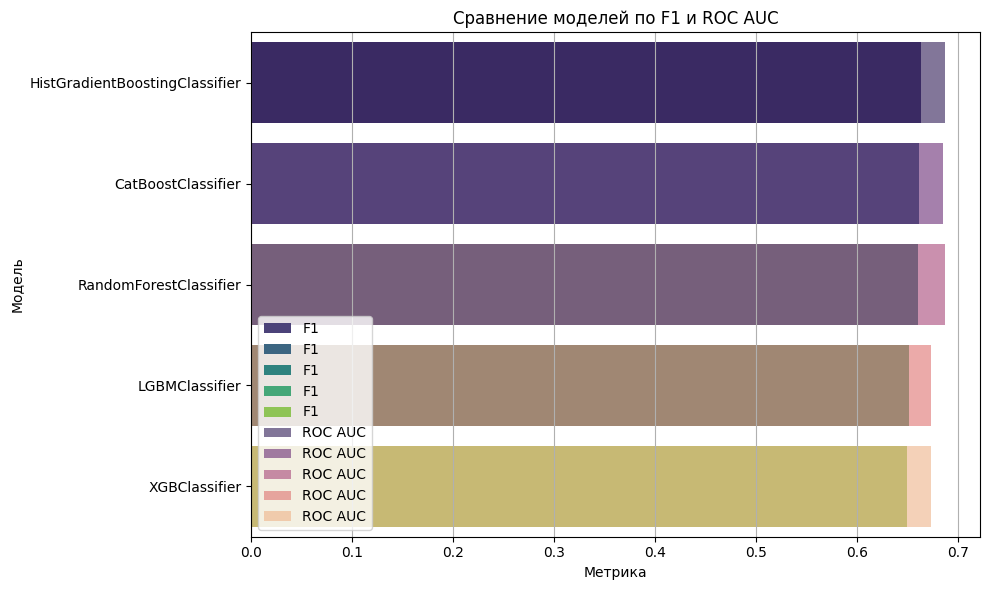

In [ ]:
results_df_sorted = results_df.sort_values(by='F1', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='F1', y='Model', data=results_df_sorted, palette='viridis', label='F1')
sns.barplot(x='ROC_AUC', y='Model', data=results_df_sorted, palette='magma', label='ROC AUC', alpha=0.6)

plt.title('Сравнение моделей по F1 и ROC AUC')
plt.xlabel('Метрика')
plt.ylabel('Модель')

# Легенда в правом нижнем углу
plt.legend(loc='lower left')

plt.grid(axis='x')
plt.tight_layout()
plt.show()

In [ ]:
# Разделение :
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, stratify=y_class, random_state=42)

# Словарь с классами моделей
model_classes = {
    'RandomForestClassifier': RandomForestClassifier,
    'HistGradientBoostingClassifier': HistGradientBoostingClassifier,
    'XGBClassifier': XGBClassifier,
    'LGBMClassifier': LGBMClassifier,
    'CatBoostClassifier': CatBoostClassifier
}

# Восстанавливаем лучшие модели
best_models = {}

for _, row in results_df.iterrows():
    model_name = row['Model']
    best_params = row['Best_Params']
    model_class = model_classes[model_name]

    # Убираем лишние параметры, если они есть
    if model_name == 'HistGradientBoostingClassifier':
        best_params.pop('random_state', None)

    model = model_class(**best_params, random_state=42)
    model.fit(X_train, y_train)
    best_models[model_name] = model

[LightGBM] [Info] Number of positive: 375, number of negative: 425
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16832
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 160
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.468750 -> initscore=-0.125163
[LightGBM] [Info] Start training from score -0.125163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

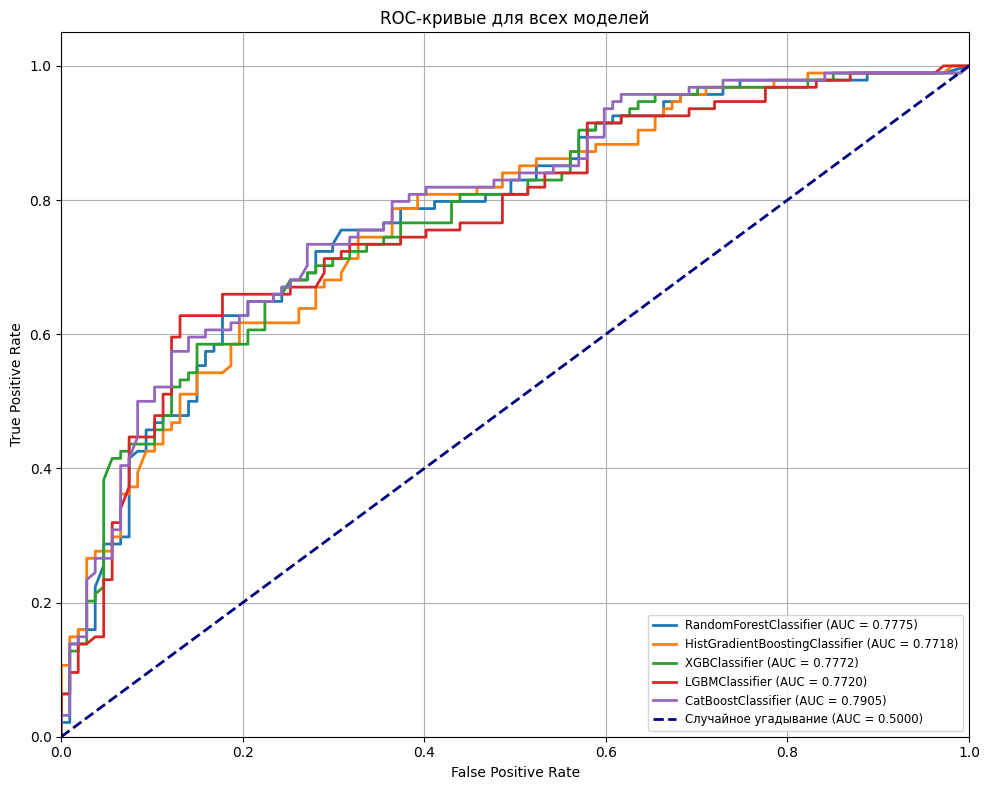

In [ ]:
plt.figure(figsize=(10, 8))

for model_name, model in best_models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.predict(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.4f})')

# Диагональ случайного гадания
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Случайное угадывание (AUC = 0.5000)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для всех моделей')
plt.legend(loc="lower right", fontsize='small')  # Легенда в правом нижнем углу
plt.grid(True)
plt.tight_layout()
plt.show()


После оптимизации гиперпараметров с помощью Optuna, лучшие параметры были получены для каждой модели. Однако, эти параметры были найдены на основе кросс-валидации (например, StratifiedKFold). Для получения финальных оценок качества моделей на независимой тестовой выборке , было решено:

    Обучить каждую модель заново  на всей обучающей выборке  (X_train, y_train) с использованием лучших параметров.
    Оценить качество моделей  на независимой тестовой выборке  (X_test, y_test).
     

Это позволило получить более точные и стабильные оценки качества моделей, так как:

    Модели обучались на полной обучающей выборке , что обычно приводит к лучшему качеству предсказаний.
    Качество моделей было проверено на независимых данных , что гарантирует отсутствие переобучени

###  Сравнение метрик до и после повторного обучения

| Модель | F1 (валидация) | F1 (тест) | ROC AUC (валидация) | ROC AUC (тест) |
|--------|----------------|-----------|----------------------|---------------|
| **HistGradientBoostingClassifier** | 0.6637 | **0.7718** | 0.6870 | **0.7718** |
| **CatBoostClassifier** | 0.6609 | **0.7953** | 0.6853 | **0.7953** |
| **RandomForestClassifier** | 0.6608 | **0.7775** | 0.6874 | **0.7775** |
| **LGBMClassifier** | 0.6511 | **0.7720** | 0.6734 | **0.7720** |
| **XGBClassifier** | 0.6496 | **0.7720** | 0.6731 | **0.7720** |

Выводы по результатам  

  После повторного обучения на всей обучающей выборке CatBoostClassifier  продемонстрировал лучший результат  по обоим метрикам: F1 = 0.7953 и ROC AUC = 0.7953.
  HistGradientBoostingClassifier  также показал высокое качество (F1 = 0.7718, ROC AUC = 0.7718), но немного уступает CatBoost.
  Остальные модели (RandomForest, LGBM, XGBoost) имеют близкие значения метрик (~0.77).
     